In [1]:
import pandas as pd
import torch
import ltn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 1. Initial data analysis

In [3]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)
data_info = data.info()
data_head = data.head()
data_description = data.describe()
(data_info, data_head, data_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59442 entries, 0 to 59441
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _time                       59442 non-null  object 
 1   GARAGE_EXTERNAL_POWER       59442 non-null  float64
 2   DEMAND_LIMIT                59442 non-null  float64
 3   DEMAND_LIMIT_INDICATOR      59442 non-null  float64
 4   BATTERY_SOC                 59442 non-null  float64
 5   BATTERY_DISCHARGE_POWER     59442 non-null  float64
 6   BATTERY_CHARGED_ENERGY      59442 non-null  float64
 7   BATTERY_DISCHARGED_ENERGY   59442 non-null  float64
 8   PV_POWER                    59442 non-null  float64
 9   PV_ENERGY                   59442 non-null  float64
 10  WALLBOX_ALPHA_ENERGY        59442 non-null  float64
 11  WALLBOX_ALPHA_POWER         59442 non-null  float64
 12  WALLBOX_1_ENERGY            59442 non-null  float64
 13  WALLBOX_1_POWER             594

(None,
                        _time  GARAGE_EXTERNAL_POWER  DEMAND_LIMIT  \
 0  2023-10-05 00:01:00+00:00               1.244171          50.0   
 1  2023-10-05 00:02:00+00:00               1.244171          50.0   
 2  2023-10-05 00:03:00+00:00               1.244171          50.0   
 3  2023-10-05 00:04:00+00:00               1.244171          50.0   
 4  2023-10-05 00:05:00+00:00               1.244171          50.0   
 
    DEMAND_LIMIT_INDICATOR  BATTERY_SOC  BATTERY_DISCHARGE_POWER  \
 0                     1.0         40.5                   -0.338   
 1                     1.0         40.5                   -0.372   
 2                     1.0         40.5                   -0.393   
 3                     1.0         40.5                   -0.339   
 4                     1.0         40.5                   -0.371   
 
    BATTERY_CHARGED_ENERGY  BATTERY_DISCHARGED_ENERGY  PV_POWER  PV_ENERGY  \
 0                     0.0                        0.0  0.008693        0.0   
 1   

In [ ]:
# Rule 1: SOC > 80%
mask_soc_above_80 = data['BATTERY_SOC'] > 80

# Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_40_to_80_high_power = (data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] < 80) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3a: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_below_40_high_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3b: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
mask_below_40_low_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] < data['DEMAND_LIMIT'])

# Rule 4: SOC < 15%
mask_below_15 = data['BATTERY_SOC'] < 15


data_soc_above_80 = data[mask_soc_above_80]
data_40_to_80_high_power = data[mask_40_to_80_high_power]
data_below_40_high_power = data[mask_below_40_high_power]
data_below_40_low_power = data[mask_below_40_low_power]
data_below_15 = data[mask_below_15]
count_rules = {
    "SOC > 80%": len(data_soc_above_80),
    "40% < SOC < 80% and High Power": len(data_40_to_80_high_power),
    "SOC < 40% and High Power": len(data_below_40_high_power),
    "SOC < 40% and Low Power": len(data_below_40_low_power),
    "SOC < 15%": len(data_below_15)
}

count_rules


In [ ]:
counts_df = pd.DataFrame(list(count_rules.items()), columns=['Rule', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(counts_df['Rule'], counts_df['Count'], color='skyblue')
plt.xlabel('SOC Rules')
plt.ylabel('Number of Entries')
plt.title('Distribution of Entries by SOC Rules')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

plt.show()


In [ ]:
total_entries_covered = sum(count_rules.values())
total_entries_covered

In [ ]:
len(data)

### 2. Create new datset  which corresponds to the following ground rules 

In [ ]:
# Combine all the filtered datasets into one that satisfies any of the rules
combined_data = pd.concat([
    data_soc_above_80,
    data_40_to_80_high_power,
    data_below_40_high_power,
    data_below_40_low_power,
    data_below_15
])
# Drop duplicate entries if any entry matches multiple rules
combined_data = combined_data.drop_duplicates()
# Save the combined dataset to a new CSV file
output_file_path = 'Filtered_Emobility_Data.csv'
combined_data.to_csv(output_file_path, index=False)




In [ ]:
data_modified = pd.read_csv(output_file_path)

In [ ]:
# Define the rules based on SOC
def evaluate_rules(df):
    # Rule 1: SOC > 80%
    rule1 = (df['BATTERY_SOC'] > 80)
    # Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule2 = (df['BATTERY_SOC'] > 40) & (df['BATTERY_SOC'] < 80) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])
    # Rule 3: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule3 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])
    # Rule 4: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
    rule4 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] < df['DEMAND_LIMIT'])
    # Rule 5: SOC < 15% (Battery discharging stopped)
    rule5 = (df['BATTERY_SOC'] < 15)
    rule1_sat = rule1.mean()
    rule2_sat = rule2.mean()
    rule3_sat = rule3.mean()
    rule4_sat = rule4.mean()
    rule5_sat = rule5.mean()

    return {
        "Rule 1 (SOC > 80%)": rule1_sat,
        "Rule 2 (40% < SOC < 80%)": rule2_sat,
        "Rule 3 (SOC < 40% and POWER > LIMIT)": rule3_sat,
        "Rule 4 (SOC < 40% and POWER < LIMIT)": rule4_sat,
        "Rule 5 (SOC < 15%)": rule5_sat
    }
rule_satisfaction = evaluate_rules(data)
rule_satisfaction


### 3. Checking on whole dataset

In [ ]:
rule_satisfaction = evaluate_rules(data)
rule_satisfaction


### 4. Tourch NN

In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim


# Convert '_time' from string to datetime
data['_time'] = pd.to_datetime(data['_time'])

# Assume we're using all columns except '_time' and 'BATTERY_SOC' as features
features = data.drop(columns=['_time', 'BATTERY_SOC'])
targets = data['BATTERY_SOC']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to numpy arrays
features_numpy = np.array(features_scaled, dtype=np.float32)
targets_numpy = np.array(targets.values, dtype=np.float32).reshape(-1, 1)  # Reshape to make it a column vector

# Neural network model
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super(BatteryManagementModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(features.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define accuracy for regression
def regression_accuracy(outputs, targets, threshold=5.0):
    correct = (torch.abs(outputs - targets) <= threshold).float()
    accuracy = correct.mean()
    return accuracy.item() * 100

# Manual batching
def manual_batching(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Training function
def train(model, features, targets, batch_size=64, epochs=100):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        indices = np.arange(features_tensor.shape[0])
        np.random.shuffle(indices)
        for batch_indices in manual_batching(indices, batch_size):
            batch_features = features_tensor[batch_indices]
            batch_targets = targets_tensor[batch_indices]
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += regression_accuracy(outputs, batch_targets)
        average_loss = running_loss / (len(indices) / batch_size)
        average_accuracy = running_accuracy / (len(indices) / batch_size)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}, Accuracy: {average_accuracy:.2f}%')

# Testing function
def test(model, features, targets, batch_size=64):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    count = 0
    with torch.no_grad():
        for batch_features, batch_targets in zip(manual_batching(features_tensor, batch_size), manual_batching(targets_tensor, batch_size)):
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item() * batch_features.size(0)
            total_accuracy += regression_accuracy(outputs, batch_targets)
            count += 1
    average_loss = total_loss / len(features)
    average_accuracy = total_accuracy / count
    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {average_accuracy:.2f}%')

# Train and test the model
train(model, features_numpy, targets_numpy, batch_size=64, epochs=100)
test(model, features_numpy, targets_numpy, batch_size=64)


Epoch 1/100, Loss: 200.4523, Accuracy: 68.07%
Epoch 2/100, Loss: 36.9687, Accuracy: 83.90%
Epoch 3/100, Loss: 25.0592, Accuracy: 85.86%
Epoch 4/100, Loss: 21.4624, Accuracy: 86.45%
Epoch 5/100, Loss: 18.7119, Accuracy: 87.06%
Epoch 6/100, Loss: 16.9071, Accuracy: 87.47%
Epoch 7/100, Loss: 16.0446, Accuracy: 87.81%
Epoch 8/100, Loss: 15.0391, Accuracy: 87.85%
Epoch 9/100, Loss: 14.6945, Accuracy: 88.01%
Epoch 10/100, Loss: 13.9870, Accuracy: 88.33%
Epoch 11/100, Loss: 13.5173, Accuracy: 88.67%
Epoch 12/100, Loss: 13.4098, Accuracy: 88.88%
Epoch 13/100, Loss: 13.1387, Accuracy: 88.99%
Epoch 14/100, Loss: 13.1215, Accuracy: 89.12%
Epoch 15/100, Loss: 12.9480, Accuracy: 89.45%
Epoch 16/100, Loss: 12.6146, Accuracy: 89.50%
Epoch 17/100, Loss: 12.4682, Accuracy: 89.74%
Epoch 18/100, Loss: 12.6994, Accuracy: 89.82%
Epoch 19/100, Loss: 12.3238, Accuracy: 90.02%
Epoch 20/100, Loss: 12.1841, Accuracy: 90.21%
Epoch 21/100, Loss: 12.0701, Accuracy: 90.19%
Epoch 22/100, Loss: 12.1521, Accuracy: 90.

### 5. Rules satisfaction wirh LTN

In [ ]:
import ltn.fuzzy_ops as fuzzy_ops

In [15]:
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 4),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()
# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return model(inputs)
# Define the logical rules
def rule1():
    condition = soc_tensor > 80 
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 0])
def rule2():
    condition = (soc_tensor > 40) & (soc_tensor < 80) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 1])
def rule3a():
    condition = (soc_tensor < 40) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 2])
def rule3b():
    condition = (soc_tensor < 40) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 3])
def rule4():
    condition = soc_tensor < 15 
    # Directly using the corresponding output for when SOC is less than 15%
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3a = rule3a()
    satisfaction_rule3b = rule3b()
    satisfaction_rule4 = rule4()
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3a, satisfaction_rule3b, satisfaction_rule4]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Satisfaction Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3a {satisfaction_rule3a.item()}, Rule3b {satisfaction_rule3b.item()}, Rule4 {satisfaction_rule4.item()}")


Epoch 0: Loss 0.9827715754508972, Satisfaction Rule1 0.0, Rule2 0.00675036059692502, Rule3a 0.05906805768609047, Rule3b 0.01919681206345558, Rule4 0.0011268861126154661
Epoch 1: Loss 0.9821548461914062, Satisfaction Rule1 0.0, Rule2 0.006931571755558252, Rule3a 0.05905890837311745, Rule3b 0.021941298618912697, Rule4 0.0012940019369125366
Epoch 2: Loss 0.9814777374267578, Satisfaction Rule1 0.0, Rule2 0.007102663628757, Rule3a 0.05904925614595413, Rule3b 0.024994000792503357, Rule4 0.0014652942772954702
Epoch 3: Loss 0.9807373285293579, Satisfaction Rule1 0.0, Rule2 0.007262161932885647, Rule3a 0.059038981795310974, Rule3b 0.02837485633790493, Rule4 0.0016375066479668021
Epoch 4: Loss 0.9799312949180603, Satisfaction Rule1 0.0, Rule2 0.007411011029034853, Rule3a 0.059028055518865585, Rule3b 0.032096415758132935, Rule4 0.001808048109523952
Epoch 5: Loss 0.9790573716163635, Satisfaction Rule1 0.0, Rule2 0.007550111971795559, Rule3a 0.05901656299829483, Rule3b 0.03617183119058609, Rule4 0.

### 5.1 Rules from Urh, provided by LNN

SOC < 18%:

Battery Discharge Stopped due to Battery Health: This region suggests that when the SOC is below 18%, discharging of the battery is stopped to preserve the health of the battery. This is likely a protective measure to avoid deep discharge cycles that can significantly reduce battery lifespan.

18 % ≤ SOC ≤ 44%:

Battery Charged from Grid: In this SOC range, the battery is primarily charged from the grid. This could imply that the battery charges when there is excess power available from the grid or when it is economically feasible to do so. This range suggests a stable operation where the battery maintains a healthy charge level without risking deep discharge.


SOC > 44%:

Partially Covered by Local Battery: When the SOC is above 80%, the local battery partially covers the power demands. This might indicate that the battery has enough charge to support some operations independently, but not fully, perhaps to maintain a reserve of charge for peak demands or emergencies.

In [12]:
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)

class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 4),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return model(inputs)

# Define the logical rules
def rule1():
    condition = soc_tensor > 44 & (external_power_tensor > demand_limit_tensor) & (discard_power_tensor >= 0)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 0])

def rule2():
    condition = (soc_tensor >= 18) & (soc_tensor <= 44) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 1])

def rule3():
    condition = (soc_tensor <= 18) & (external_power_tensor < demand_limit_tensor) & (discard_power_tensor <= 0)
    return torch.mean(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 2])


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3 = rule3()
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Satisfaction Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")


Epoch 0: Loss 0.8260588645935059, Satisfaction Rule1 0.23008480668067932, Rule2 0.2896544635295868, Rule3 0.0020840552169829607
Epoch 10: Loss 0.5835648775100708, Satisfaction Rule1 0.5663254261016846, Rule2 0.6806371808052063, Rule3 0.002342838328331709
Epoch 20: Loss 0.4297783374786377, Satisfaction Rule1 0.8859991431236267, Rule2 0.8220874667167664, Rule3 0.0025784068275243044
Epoch 30: Loss 0.39324063062667847, Satisfaction Rule1 0.9737333059310913, Rule2 0.8438789248466492, Rule3 0.002666034735739231
Epoch 40: Loss 0.38618677854537964, Satisfaction Rule1 0.9898387789726257, Rule2 0.8489103317260742, Rule3 0.002690457971766591
Epoch 50: Loss 0.3842203617095947, Satisfaction Rule1 0.9940156936645508, Rule2 0.8506248593330383, Rule3 0.0026984780561178923
Epoch 60: Loss 0.3834320306777954, Satisfaction Rule1 0.9955916404724121, Rule2 0.851410448551178, Rule3 0.002701836172491312
Epoch 70: Loss 0.38301217555999756, Satisfaction Rule1 0.9963915944099426, Rule2 0.851868212223053, Rule3 0

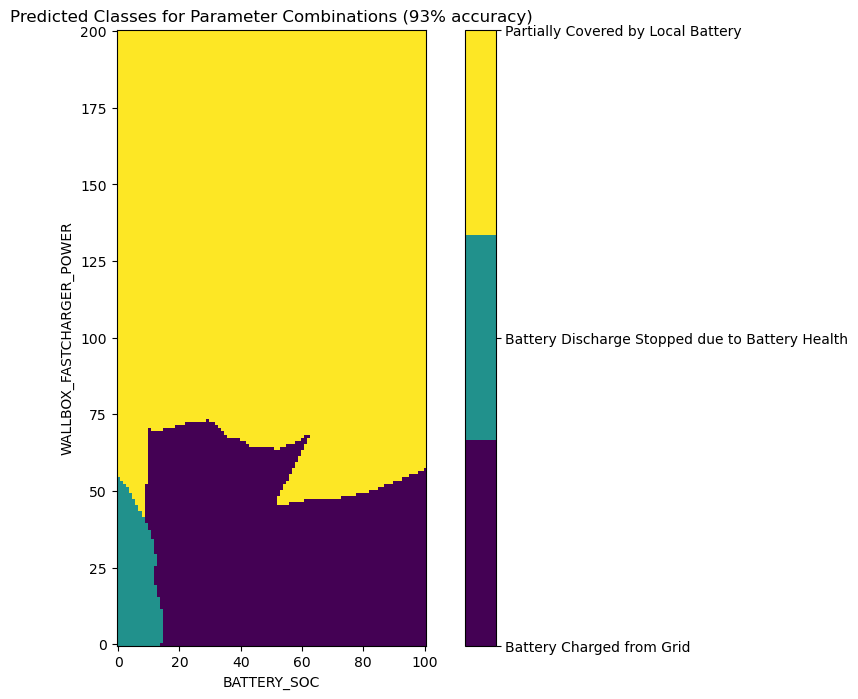

In [21]:
from IPython.display import Image

# Display the uploaded image
image_path = '/Users/jevgenijposaskov/LTN/image.png'
Image(filename=image_path)


In [19]:
# Convert the relevant data columns into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
fastcharger_power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)
# Define the BatteryManagementModel class
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 6),  # Adjusted to output 6 classes for 6 rules
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Define the conditions function
def conditions(soc, fastcharger_power):
    inputs = torch.stack([soc, fastcharger_power], dim=1)
    return model(inputs)
# Define the logical rules based on given conditions
def rule1():
    condition = (fastcharger_power_tensor <= 50) & (soc_tensor <= 17) & (discard_power_tensor < 0)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 0])
def rule2():
    condition = (fastcharger_power_tensor <= 73) & (soc_tensor > 17) & (soc_tensor <= 50) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 1])
def rule3():
    condition = (fastcharger_power_tensor <= 55) & (soc_tensor > 50) & (soc_tensor <= 100) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 2])
def rule4():
    condition = (fastcharger_power_tensor >= 50) & (fastcharger_power_tensor <= 73) & (soc_tensor > 0) & (soc_tensor <= 17) & (external_power_tensor > demand_limit_tensor) & (discard_power_tensor >= 0)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 3])
def rule5():
    condition = (fastcharger_power_tensor >= 50) & (fastcharger_power_tensor <= 73) & (soc_tensor >= 50) & (soc_tensor < 100) & (external_power_tensor > demand_limit_tensor) & (discard_power_tensor >= 0)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 4])
def rule6():
    condition = (fastcharger_power_tensor > 73) & (external_power_tensor > demand_limit_tensor) 
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 5])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3 = rule3()
    satisfaction_rule4 = rule4()
    satisfaction_rule5 = rule5()
    satisfaction_rule6 = rule6()
    
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3, satisfaction_rule4, satisfaction_rule5, satisfaction_rule6]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}, Rule4 {satisfaction_rule4.item()}, Rule5 {satisfaction_rule5.item()}, Rule6 {satisfaction_rule6.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}, Rule4 {satisfaction_rule4.item()}, Rule5 {satisfaction_rule5.item()}, Rule6 {satisfaction_rule6.item()}")


Epoch 0: Loss 0.8556275963783264, Rule1 0.0014130126219242811, Rule2 0.8246321678161621, Rule3 0.03956899419426918, Rule4 0.000300202751532197, Rule5 3.4630108984856633e-06, Rule6 0.00031646943534724414
Epoch 10: Loss 0.8515510559082031, Rule1 0.0015930382069200277, Rule2 0.8381232619285583, Rule3 0.04899785667657852, Rule4 0.0003721952671185136, Rule5 1.0289286365150474e-05, Rule6 0.0015970913227647543
Epoch 20: Loss 0.8493605852127075, Rule1 0.0018651299178600311, Rule2 0.8406534790992737, Rule3 0.05056682601571083, Rule4 0.00039393967017531395, Rule5 4.062264270032756e-05, Rule6 0.010316415689885616
Epoch 30: Loss 0.8458167314529419, Rule1 0.002153797773644328, Rule2 0.8412253260612488, Rule3 0.050911370664834976, Rule4 0.00039417119114659727, Rule5 0.00016748503549024463, Rule6 0.030247516930103302
Epoch 40: Loss 0.8451665043830872, Rule1 0.0023658580612391233, Rule2 0.8414269685745239, Rule3 0.051027409732341766, Rule4 0.00039693753933534026, Rule5 0.00031332348589785397, Rule6 0.

Let's define areas within boundares 

In [24]:
# Convert the relevant data columns into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
fastcharger_power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)

# Define the BatteryManagementModel class
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 3),  # Adjusted to output 3 classes for 3 rules
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Define the conditions function
def conditions(soc, fastcharger_power):
    inputs = torch.stack([soc, fastcharger_power], dim=1)
    return model(inputs)

# Define the logical rules based on given conditions
def rule1():
    condition = (fastcharger_power_tensor <= 40) & (soc_tensor >= 15) & (soc_tensor < 17) & (discard_power_tensor < 0)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 0])

def rule2():
    condition = (fastcharger_power_tensor <= 35) & (soc_tensor > 20) & (soc_tensor <= 50) & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 1])

def rule3():
    condition = (fastcharger_power_tensor > 73) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 2])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3 = rule3()
    
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")


Epoch 0: Loss 0.9848847985267639, Rule1 0.00034792281803674996, Rule2 0.011179439723491669, Rule3 0.0338183268904686
Epoch 10: Loss 0.9743488430976868, Rule1 0.00046795682283118367, Rule2 0.04263443872332573, Rule3 0.033851057291030884
Epoch 20: Loss 0.9418965578079224, Rule1 0.0005562968435697258, Rule2 0.139899343252182, Rule3 0.03385469689965248
Epoch 30: Loss 0.8820865750312805, Rule1 0.000611920258961618, Rule2 0.3192724883556366, Rule3 0.033855829387903214
Epoch 40: Loss 0.8125173449516296, Rule1 0.0006424360326491296, Rule2 0.5279495120048523, Rule3 0.03385598585009575
Epoch 50: Loss 0.7660258412361145, Rule1 0.0006688291905447841, Rule2 0.6673969626426697, Rule3 0.03385675325989723
Epoch 60: Loss 0.745387077331543, Rule1 0.0006993411225266755, Rule2 0.7292790412902832, Rule3 0.03386031463742256
Epoch 70: Loss 0.7357732057571411, Rule1 0.0007277404656633735, Rule2 0.7580898404121399, Rule3 0.033862899988889694
Epoch 80: Loss 0.7311300039291382, Rule1 0.0007530958973802626, Rule2

Let's try exact values 

In [25]:
# Convert the relevant data columns into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
fastcharger_power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)

# Define the BatteryManagementModel class
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 3),  # Adjusted to output 3 classes for 3 rules
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Define the conditions function
def conditions(soc, fastcharger_power):
    inputs = torch.stack([soc, fastcharger_power], dim=1)
    return model(inputs)

# Define the logical rules based on given conditions
def rule1():
    condition = (fastcharger_power_tensor == 40) & (soc_tensor == 17)  & (discard_power_tensor < 0)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 0])

def rule2():
    condition = (fastcharger_power_tensor == 25) & (soc_tensor == 30)  & (external_power_tensor < demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 1])

def rule3():
    condition = (fastcharger_power_tensor == 77) & (external_power_tensor > demand_limit_tensor)
    return torch.mean(condition.float() * conditions(soc_tensor, fastcharger_power_tensor)[:, 2])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction_rule1 = rule1()
    satisfaction_rule2 = rule2()
    satisfaction_rule3 = rule3()
    
    overall_satisfaction = torch.mean(torch.stack([satisfaction_rule1, satisfaction_rule2, satisfaction_rule3]))
    loss = 1 - overall_satisfaction
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")

print(f"Final Loss: {loss.item()}, Final Satisfaction Levels: Rule1 {satisfaction_rule1.item()}, Rule2 {satisfaction_rule2.item()}, Rule3 {satisfaction_rule3.item()}")


Epoch 0: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 10: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 20: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 30: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 40: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 50: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 60: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 70: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 80: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 90: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 100: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 110: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 120: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 130: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 140: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 150: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 160: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 170: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoch 180: Loss 1.0, Rule1 0.0, Rule2 0.0, Rule3 0.0
Epoc

### 6. Accuracy for my LTN (initial rules) 

In [151]:
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)

In [152]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [153]:
model_high_soc = SimpleMLP(input_dim=1)
model_medium_soc = SimpleMLP(input_dim=1)
model_low_soc = SimpleMLP(input_dim=1)
model_very_low_soc = SimpleMLP(input_dim=1)
model_power_above = SimpleMLP(input_dim=1)
# Recreate the model with the correct input dimension
model_power_above = SimpleMLP(input_dim=2)  # Adjusted from 1 to 2

In [154]:
def custom_implies(p, q):
    """ Implements logical implication using tensors: p → q is ¬p ∨ q """
    return torch.logical_or(~p.bool(), q.bool())
SOC = torch.tensor(data['BATTERY_SOC'].values).float() / 100
GARAGE_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values).float()
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values).float()
# Example of a condition: SOC > 0.8 (high SOC)
high_soc_output = model_high_soc(SOC.unsqueeze(1))
high_soc_condition = (SOC > 0.8).unsqueeze(1)
high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
# Continue from previous definitions
# Middle SOC Condition: 40% < SOC < 80%
medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)  # Ensure target condition has the same shape as output
medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
# If GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)  # Match the shape
power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
# Low SOC Condition: SOC < 40%
low_soc_output = model_low_soc(SOC.unsqueeze(1))
low_soc_condition = (SOC < 0.4).unsqueeze(1)  # Ensure target condition has the same shape as output
low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
# Very Low SOC Condition: SOC < 15%
very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
very_low_soc_condition = (SOC < 0.15).unsqueeze(1)  # Match the shape
very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [155]:
def calculate_accuracy(outputs, targets):
    predicted = outputs.round()  # Round to 0 or 1
    correct = (predicted == targets).float()  # Correct predictions
    accuracy = correct.sum() / len(correct)  # Mean accuracy
    return accuracy


In [156]:
accuracies = []
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    # Recalculate each output inside the loop
    high_soc_output = model_high_soc(SOC.unsqueeze(1))
    medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
    power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
    low_soc_output = model_low_soc(SOC.unsqueeze(1))
    very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
    # Recalculate conditions
    high_soc_condition = (SOC > 0.8).unsqueeze(1)
    medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)
    power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
    low_soc_condition = (SOC < 0.4).unsqueeze(1)
    very_low_soc_condition = (SOC < 0.15).unsqueeze(1)
    # Recalculate losses
    high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
    medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
    power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
    low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
    very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())
    # Combine all losses
    total_loss = (high_soc_loss + medium_soc_loss + power_above_loss + low_soc_loss + very_low_soc_loss)
    total_loss.backward()
    optimizer.step()
    # Calculate accuracy for each model
    high_soc_accuracy = calculate_accuracy(high_soc_output, high_soc_condition.float())
    medium_soc_accuracy = calculate_accuracy(medium_soc_output, medium_soc_condition.float())
    power_above_accuracy = calculate_accuracy(power_above_output, power_above_condition.float())
    low_soc_accuracy = calculate_accuracy(low_soc_output, low_soc_condition.float())
    very_low_soc_accuracy = calculate_accuracy(very_low_soc_output, very_low_soc_condition.float())
    # Aggregate accuracies and losses
    mean_accuracy = np.mean([high_soc_accuracy.item(), medium_soc_accuracy.item(), 
                             power_above_accuracy.item(), low_soc_accuracy.item(), 
                             very_low_soc_accuracy.item()])
    accuracies.append(mean_accuracy)
    losses.append(total_loss.item())

    print(f"Epoch {epoch}, Loss: {total_loss.item()}, Mean Accuracy: {mean_accuracy}")
# Calculate final mean accuracy and satisfaction
final_mean_accuracy = np.mean(accuracies)
final_mean_loss = np.mean(losses)
print(f"Final Mean Accuracy: {final_mean_accuracy}, Final Mean Loss (Satisfaction): {final_mean_loss}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 6.1 Accuracy for Urh's rules

In [29]:
# Convert the relevant data columns into tensors
SOC = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32) / 100
GARAGE_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discard_power_tensor = torch.tensor(data["BATTERY_DISCHARGE_POWER"].values, dtype=torch.float32)

# Define the SimpleMLP class
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
model_high_soc = SimpleMLP(input_dim=1)
model_medium_soc = SimpleMLP(input_dim=1)
model_low_soc = SimpleMLP(input_dim=1)
model_very_low_soc = SimpleMLP(input_dim=1)
model_power_above = SimpleMLP(input_dim=2) 
optimizer = optim.Adam(list(model_high_soc.parameters()) +
                       list(model_medium_soc.parameters()) +
                       list(model_low_soc.parameters()) +
                       list(model_very_low_soc.parameters()) +
                       list(model_power_above.parameters()), lr=0.001)

def calculate_accuracy(outputs, targets):
    predicted = outputs.round()  # Round to 0 or 1
    correct = (predicted == targets).float()  # Correct predictions
    accuracy = correct.sum() / len(correct)  
    return accuracy
accuracies = []
losses = []
for epoch in range(1000):  
    # Recalculate each output inside the loop
    high_soc_output = model_high_soc(SOC.unsqueeze(1))
    medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
    power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
    low_soc_output = model_low_soc(SOC.unsqueeze(1))
    very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
    # Recalculate conditions
    high_soc_condition = (SOC > 0.44).unsqueeze(1)
    medium_soc_condition = ((SOC >= 0.18) & (SOC <= 0.44)).unsqueeze(1)
    power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
    low_soc_condition = (SOC <= 0.18).unsqueeze(1)
    very_low_soc_condition = ((SOC <= 0.18) & (discard_power_tensor <= 0)).unsqueeze(1)
    # Recalculate losses
    high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
    medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
    power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
    low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
    very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())
    # Combine all losses
    total_loss = (high_soc_loss + medium_soc_loss + power_above_loss + low_soc_loss + very_low_soc_loss)
    total_loss.backward()
    optimizer.step()
    # Calculate accuracy for each model
    high_soc_accuracy = calculate_accuracy(high_soc_output, high_soc_condition.float())
    medium_soc_accuracy = calculate_accuracy(medium_soc_output, medium_soc_condition.float())
    power_above_accuracy = calculate_accuracy(power_above_output, power_above_condition.float())
    low_soc_accuracy = calculate_accuracy(low_soc_output, low_soc_condition.float())
    very_low_soc_accuracy = calculate_accuracy(very_low_soc_output, very_low_soc_condition.float())
    # Aggregate accuracies and losses
    mean_accuracy = np.mean([high_soc_accuracy.item(), medium_soc_accuracy.item(), 
                             power_above_accuracy.item(), low_soc_accuracy.item(), 
                             very_low_soc_accuracy.item()])
    accuracies.append(mean_accuracy)
    losses.append(total_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch},  Mean Accuracy: {mean_accuracy}")

# Calculate final mean accuracy and satisfaction
final_mean_accuracy = np.mean(accuracies)
print(f"Final Mean Accuracy: {final_mean_accuracy}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 7. An attemp to execute some rules (ToDo)

!!! This part is silly. It isn't finished yet. 


In [122]:

SOC = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).reshape(-1, 1)
GARAGE_EXTERNAL_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).reshape(-1, 1)
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).reshape(-1, 1)

high_threshold = torch.nn.Parameter(torch.tensor([0.8]))
mid_threshold_low = torch.nn.Parameter(torch.tensor([0.4]))
mid_threshold_high = torch.nn.Parameter(torch.tensor([0.8]))
low_threshold = torch.nn.Parameter(torch.tensor([0.4]))
very_low_threshold = torch.nn.Parameter(torch.tensor([0.15]))

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def greater_than(x, threshold):
    return sigmoid(10 * (x - threshold))

def less_than(x, threshold):
    return 1 - greater_than(x, threshold)

def between(x, low, high):
    return greater_than(x, low) * less_than(x, high)

def is_high_SOC(soc):
    return greater_than(soc, high_threshold)

def is_mid_SOC(soc):
    return between(soc, mid_threshold_low, mid_threshold_high)

def is_low_SOC(soc):
    return less_than(soc, low_threshold)

def is_very_low_SOC(soc):
    return less_than(soc, very_low_threshold)

def power_above_demand(power, demand):
    return greater_than(power, demand)

def battery_management_logic(soc, power, demand):
    high_soc_rule = is_high_SOC(soc)
    mid_soc_rule = is_mid_SOC(soc) * power_above_demand(power, demand)
    low_soc_rule = is_low_SOC(soc) * ((power_above_demand(power, demand) + (1 - power_above_demand(power, demand))) / 2)
    very_low_soc_rule = is_very_low_SOC(soc)
    return high_soc_rule * mid_soc_rule * low_soc_rule * very_low_soc_rule
optimizer = optim.Adam([high_threshold, mid_threshold_low, mid_threshold_high, low_threshold, very_low_threshold], lr=0.01)

def train():
    for step in range(1000):
        optimizer.zero_grad()
        logic_output = battery_management_logic(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT)
        loss = 1 - logic_output.mean()  # Objective to maximize the logical satisfaction
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

train()

print("Optimized Thresholds:")
print(f"High Threshold: {high_threshold.item()}")
print(f"Mid Threshold Low: {mid_threshold_low.item()}")
print(f"Mid Threshold High: {mid_threshold_high.item()}")
print(f"Low Threshold: {low_threshold.item()}")
print(f"Very Low Threshold: {very_low_threshold.item()}")


Step 0, Loss: 1.0
Step 100, Loss: 1.0
Step 200, Loss: 1.0
Step 300, Loss: 1.0
Step 400, Loss: 1.0
Step 500, Loss: 1.0
Step 600, Loss: 1.0
Step 700, Loss: 1.0
Step 800, Loss: 1.0
Step 900, Loss: 1.0
Optimized Thresholds:
High Threshold: 0.800000011920929
Mid Threshold Low: 0.4000000059604645
Mid Threshold High: 0.800000011920929
Low Threshold: 0.4000000059604645
Very Low Threshold: 0.15000000596046448


In [ ]:
data['BATTERY_SOC_normalized'] = data['BATTERY_SOC'] / 100
data['GARAGE_EXTERNAL_POWER_normalized'] = data['GARAGE_EXTERNAL_POWER'] / data['GARAGE_EXTERNAL_POWER'].max()

# Convert to tensors
soc_tensor = torch.tensor(data['BATTERY_SOC_normalized'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER_normalized'].values, dtype=torch.float32)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 10)  
        self.fc2 = nn.Linear(10, 10) 
        self.fc3 = nn.Linear(10, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        return x


In [ ]:
# Instantiate the MLPs
high_soc_mlp = MLP()
external_gt_demand_mlp = MLP()
soc_var = ltn.Variable('soc', soc_tensor)
external_power_var = ltn.Variable('external_power', external_power_tensor)
HighSOC = ltn.Predicate(high_soc_mlp)
ExternalGreaterThanDemand = ltn.Predicate(external_gt_demand_mlp)


In [ ]:
def Implies(p, q):
    return torch.min(p, 1-q)
def Forall(variables, formula):
    return torch.mean(formula(variables))

In [ ]:
formula = ltn.Forall(soc_var, ltn.Implies(HighSOC(soc_var), ExternalGreaterThanDemand(external_power_var)))
kb = ltn.KnowledgeBase("battery_management", formula)

In [ ]:
optimizer = torch.optim.Adam(kb.parameters(), lr=0.01)
for epoch in range(1000):
    optimizer.zero_grad()
    loss = -kb()  # Minimize the negative of the KB, which maximizes the satisfaction of the KB
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


In [ ]:
with torch.no_grad():
    soc_high = HighSOC(soc_var)
    external_gt_demand = ExternalGreaterThanDemand(external_power_var)
print("High SOC Evaluation:", soc_high.mean().item())
print("External Power Greater Than Demand Evaluation:", external_gt_demand.mean().item())


In [ ]:

soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
# Ensure tensors do not require gradients
soc_tensor.requires_grad_(False)
power_tensor.requires_grad_(False)
demand_tensor.requires_grad_(False)

class IsDischarging(nn.Module):
    def __init__(self):
        super().__init__()
        self.threshold = nn.Parameter(torch.tensor([-0.5], dtype=torch.float32))

    def forward(self, x):
        return torch.sigmoid(-x - self.threshold)

class ExceedsDemand(nn.Module):
    def forward(self, power, demand):
        return torch.relu(power - demand)

class SOCRange(nn.Module):
    def __init__(self, low, high):
        super().__init__()
        self.low = nn.Parameter(torch.tensor([low], dtype=torch.float32))
        self.high = nn.Parameter(torch.tensor([high], dtype=torch.float32))

    def forward(self, soc):
        return torch.sigmoid(soc - self.low) * torch.sigmoid(self.high - soc)

# Instantiate predicates
is_discharging = IsDischarging()
exceeds_demand = ExceedsDemand()
soc_high = SOCRange(80, 100)  # Adjust high to a realistic maximum if 'inf' is inappropriate
soc_mid = SOCRange(40, 80)
soc_low = SOCRange(0, 40)
soc_very_low = SOCRange(0, 15)

def rule1(soc, power):
    return soc_high(soc) * is_discharging(power)

def rule2(soc, power, demand):
    return soc_mid(soc) * exceeds_demand(power, demand) * is_discharging(power)

def rule3(soc, power, demand):
    return soc_low(soc) * exceeds_demand(power, demand) * is_discharging(power)

def rule4(soc, power, demand):
    return soc_low(soc) * (1 - exceeds_demand(power, demand)) * (1 - is_discharging(power))

def rule5(soc, power):
    return soc_very_low(soc) * (1 - is_discharging(power))

optimizer = optim.Adam([
    {'params': is_discharging.parameters()},
    {'params': exceeds_demand.parameters()},
    {'params': soc_high.parameters()},
    {'params': soc_mid.parameters()},
    {'params': soc_low.parameters()},
    {'params': soc_very_low.parameters()}
], lr=0.01)

for epoch in range(500):
    optimizer.zero_grad()
    loss =   (rule1(soc_tensor, power_tensor) +
              rule2(soc_tensor, power_tensor, demand_tensor) +
              rule3(soc_tensor, power_tensor, demand_tensor) +
              rule4(soc_tensor, power_tensor, demand_tensor) +
              rule5(soc_tensor, power_tensor)).mean()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")
# Print learned parameters for inspection
print("Learned SOC high threshold:", soc_high.high.item())
print("Learned SOC mid range:", soc_mid.low.item(), soc_mid.high.item())
print("Learned SOC low range:", soc_low.low.item(), soc_low.high.item())


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
model_high_soc = SimpleMLP(input_dim=1)
model_medium_soc = SimpleMLP(input_dim=1)
model_low_soc = SimpleMLP(input_dim=1)
model_very_low_soc = SimpleMLP(input_dim=1)
model_power_above = SimpleMLP(input_dim=1)
# Recreate the model with the correct input dimension
model_power_above = SimpleMLP(input_dim=2)  # Adjusted from 1 to 2

In [ ]:
# Assuming GARAGE_POWER and DEMAND_LIMIT are already tensors and have been unsqueezed properly
power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())


In [ ]:
def custom_implies(p, q):
    """ Implements logical implication using tensors: p → q is ¬p ∨ q """
    return torch.logical_or(~p.bool(), q.bool())
SOC = torch.tensor(data['BATTERY_SOC'].values).float() / 100
GARAGE_POWER = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values).float()
DEMAND_LIMIT = torch.tensor(data['DEMAND_LIMIT'].values).float()
# Example of a condition: SOC > 0.8 (high SOC)
high_soc_output = model_high_soc(SOC.unsqueeze(1))
high_soc_condition = (SOC > 0.8).unsqueeze(1)
high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
# Continue from previous definitions
# Middle SOC Condition: 40% < SOC < 80%
medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)  # Ensure target condition has the same shape as output
medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
# If GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)  # Match the shape
power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
# Low SOC Condition: SOC < 40%
low_soc_output = model_low_soc(SOC.unsqueeze(1))
low_soc_condition = (SOC < 0.4).unsqueeze(1)  # Ensure target condition has the same shape as output
low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
# Very Low SOC Condition: SOC < 15%
very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
very_low_soc_condition = (SOC < 0.15).unsqueeze(1)  # Match the shape
very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())


In [ ]:
def calculate_accuracy(outputs, targets):
    predicted = outputs.round()  # Round to 0 or 1
    correct = (predicted == targets).float()  # Correct predictions
    accuracy = correct.sum() / len(correct)  # Mean accuracy
    return accuracy


In [ ]:

accuracies = []
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    # Recalculate each output inside the loop
    high_soc_output = model_high_soc(SOC.unsqueeze(1))
    medium_soc_output = model_medium_soc(SOC.unsqueeze(1))
    power_above_output = model_power_above(torch.cat([GARAGE_POWER.unsqueeze(1), DEMAND_LIMIT.unsqueeze(1)], dim=1))
    low_soc_output = model_low_soc(SOC.unsqueeze(1))
    very_low_soc_output = model_very_low_soc(SOC.unsqueeze(1))
    # Recalculate conditions
    high_soc_condition = (SOC > 0.8).unsqueeze(1)
    medium_soc_condition = ((SOC > 0.4) & (SOC < 0.8)).unsqueeze(1)
    power_above_condition = (GARAGE_POWER > DEMAND_LIMIT).unsqueeze(1)
    low_soc_condition = (SOC < 0.4).unsqueeze(1)
    very_low_soc_condition = (SOC < 0.15).unsqueeze(1)
    # Recalculate losses
    high_soc_loss = torch.nn.functional.binary_cross_entropy(high_soc_output, high_soc_condition.float())
    medium_soc_loss = torch.nn.functional.binary_cross_entropy(medium_soc_output, medium_soc_condition.float())
    power_above_loss = torch.nn.functional.binary_cross_entropy(power_above_output, power_above_condition.float())
    low_soc_loss = torch.nn.functional.binary_cross_entropy(low_soc_output, low_soc_condition.float())
    very_low_soc_loss = torch.nn.functional.binary_cross_entropy(very_low_soc_output, very_low_soc_condition.float())
    # Combine all losses
    total_loss = (high_soc_loss + medium_soc_loss + power_above_loss + low_soc_loss + very_low_soc_loss)
    total_loss.backward()
    optimizer.step()
    # Calculate accuracy for each model
    high_soc_accuracy = calculate_accuracy(high_soc_output, high_soc_condition.float())
    medium_soc_accuracy = calculate_accuracy(medium_soc_output, medium_soc_condition.float())
    power_above_accuracy = calculate_accuracy(power_above_output, power_above_condition.float())
    low_soc_accuracy = calculate_accuracy(low_soc_output, low_soc_condition.float())
    very_low_soc_accuracy = calculate_accuracy(very_low_soc_output, very_low_soc_condition.float())
    # Aggregate accuracies and losses
    mean_accuracy = np.mean([high_soc_accuracy.item(), medium_soc_accuracy.item(), 
                             power_above_accuracy.item(), low_soc_accuracy.item(), 
                             very_low_soc_accuracy.item()])
    accuracies.append(mean_accuracy)
    losses.append(total_loss.item())

    print(f"Epoch {epoch}, Loss: {total_loss.item()}, Mean Accuracy: {mean_accuracy}")
# Calculate final mean accuracy and satisfaction
final_mean_accuracy = np.mean(accuracies)
final_mean_loss = np.mean(losses)
print(f"Final Mean Accuracy: {final_mean_accuracy}, Final Mean Loss (Satisfaction): {final_mean_loss}")


In [ ]:
# Define the Predicate Neural Network
class Predicate(nn.Module):
    def __init__(self, input_dim, hidden_dim=10):
        super(Predicate, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
# Create instances for different SOC levels
IsHighSOC = Predicate(input_dim=1)
IsLowSOC = Predicate(input_dim=1)


In [ ]:
# Extract BATTERY_SOC values and convert them to a tensor
soc_real_values = torch.tensor(data['BATTERY_SOC'].values).float().reshape(-1, 1)
# Define labels based on the SOC thresholds for training
real_high_soc_labels = torch.where(soc_real_values > 80, 1, 0)  # High if SOC > 80
real_low_soc_labels = torch.where(soc_real_values < 40, 1, 0)   # Low if SOC < 20

/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)  # Ensure data is a float32 tensor
/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are float32 tensor


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1, Loss: 2.233189154432491e-11
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ext

/var/folders/5l/tkf85tcj7tb12y9v832j_prm0000gn/T/ipykernel_1610/1401064718.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  soc_values = torch.tensor(soc_values, dtype=torch.float32)  # Ensure it's a tensor


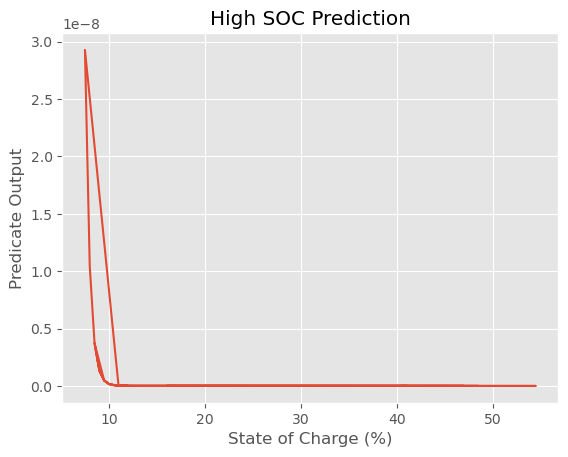

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


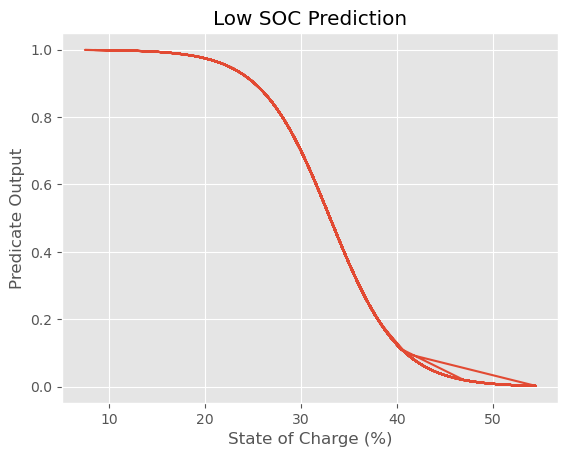

In [117]:
def train(model, data, labels, epochs=100, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    data = torch.tensor(data, dtype=torch.float32)  
    labels = torch.tensor(labels, dtype=torch.float32)  
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
def plot_model_predictions(model, soc_values, title):
    soc_values = torch.tensor(soc_values, dtype=torch.float32)  # Ensure it's a tensor
    with torch.no_grad():
        preds = model(soc_values).numpy()
    plt.plot(soc_values.numpy(), preds, label='Model Output')
    plt.title(title)
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Predicate Output')
    plt.show()
train(IsHighSOC, soc_real_values, real_high_soc_labels)
train(IsLowSOC, soc_real_values, real_low_soc_labels)
plot_model_predictions(IsHighSOC, soc_real_values, 'High SOC Prediction')
plot_model_predictions(IsLowSOC, soc_real_values, 'Low SOC Prediction')


## Dynamic dataset

In [ ]:
file_path = 'Stud_E-mobility_data_dynamicLimit.csv'
data = pd.read_csv(file_path)

In [ ]:
data.head(), data.info(), data.describe()

In [ ]:
missing_values = data.isnull().sum()
missing_values[missing_values > 0]


In [ ]:
# Plotting the external power demand vs demand limit and observing battery state of charge
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:red'
ax1.set_xlabel('Time (Index)')
ax1.set_ylabel('GARAGE_EXTERNAL_POWER & DEMAND_LIMIT', color=color)
ax1.plot(data['GARAGE_EXTERNAL_POWER'], label='Garage External Power', color='red', alpha=0.7)
ax1.plot(data['DEMAND_LIMIT'], label='Demand Limit', color='blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('BATTERY_SOC', color=color)  # we already handled the x-label with ax1
ax2.plot(data['BATTERY_SOC'], label='Battery SOC', color='green', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('External Power Demand vs. Demand Limit and Battery SOC')
plt.show()


In [ ]:
# Plotting Garage External Power vs. Demand Limit
plt.figure(figsize=(14, 6))
plt.plot(data['GARAGE_EXTERNAL_POWER'], label='Garage External Power', color='red', alpha=0.7)
plt.plot(data['DEMAND_LIMIT'], label='Demand Limit', color='blue', alpha=0.7)
plt.ylabel('Power (kW)')
plt.xlabel('Time (Index)')
plt.title('Garage External Power vs. Demand Limit')
plt.legend()
plt.show()


In [ ]:
# Filter data for events where external power exceeds the demand limit
exceed_events = data[data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT']]
# Plotting the details for these events
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
# External Power and Demand Limit
ax1.plot(exceed_events['GARAGE_EXTERNAL_POWER'], label='Garage External Power', color='red', alpha=0.7)
ax1.plot(exceed_events['DEMAND_LIMIT'], label='Demand Limit', color='blue', alpha=0.5)
ax1.set_ylabel('Power (kW)')
ax1.set_title('External Power vs. Demand Limit During Exceed Events')
ax1.legend(loc='upper right')
# Battery SOC and Discharge Power
ax2.plot(exceed_events['BATTERY_SOC'], label='Battery SOC', color='green', alpha=0.7)
ax2.set_ylabel('State of Charge (%)')
ax2.set_xlabel('Time (Index)')
ax2.legend(loc='upper left')
# Adding a second y-axis to show discharge power
ax3 = ax2.twinx()
ax3.plot(exceed_events['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='purple', alpha=0.5)
ax3.set_ylabel('Discharge Power (kW)')
ax3.legend(loc='upper right')

plt.show()


In [ ]:
# Calculating basic statistics for events where external power exceeds the demand limit
exceed_stats = {
    'Number of Exceed Events': exceed_events.shape[0],
    'Average SOC When Exceeding': exceed_events['BATTERY_SOC'].mean(),
    'Median SOC When Exceeding': exceed_events['BATTERY_SOC'].median(),
    'Average Discharge Power When Exceeding': exceed_events['BATTERY_DISCHARGE_POWER'].mean(),
    'Median Discharge Power When Exceeding': exceed_events['BATTERY_DISCHARGE_POWER'].median()
}



In [ ]:
exceed_stats

In [ ]:
# Define conditions based on SOC and external power to check compliance
high_soc = data[data['BATTERY_SOC'] > 80]
mid_soc = data[(data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] <= 80)]
low_soc = data[data['BATTERY_SOC'] <= 40]
very_low_soc = data[data['BATTERY_SOC'] < 15]

# Checking rule compliance for High SOC (> 80%)
high_soc_compliance = (high_soc['BATTERY_DISCHARGE_POWER'] > 0).mean()

# Checking rule compliance for Mid-Level SOC (40%-80%)
# Should discharge battery when external power exceeds limit
mid_soc_exceed = mid_soc[mid_soc['GARAGE_EXTERNAL_POWER'] > mid_soc['DEMAND_LIMIT']]
mid_soc_compliance = (mid_soc_exceed['BATTERY_DISCHARGE_POWER'] > 0).mean()

# Checking rule compliance for Low SOC (< 40%)
# Should discharge battery when external power exceeds limit
low_soc_exceed = low_soc[low_soc['GARAGE_EXTERNAL_POWER'] > low_soc['DEMAND_LIMIT']]
low_soc_compliance_exceed = (low_soc_exceed['BATTERY_DISCHARGE_POWER'] > 0).mean()

# Should charge battery when external power is below limit
low_soc_not_exceed = low_soc[low_soc['GARAGE_EXTERNAL_POWER'] <= low_soc['DEMAND_LIMIT']]
low_soc_compliance_not_exceed = (low_soc_not_exceed['BATTERY_DISCHARGE_POWER'] <= 0).mean()

# Checking for very low SOC (< 15%)
# Battery discharging should be stopped
very_low_soc_compliance = (very_low_soc['BATTERY_DISCHARGE_POWER'] == 0).mean()

# Compile results
compliance_results = {
    'High SOC (>80%) Discharge Compliance': high_soc_compliance,
    'Mid SOC (40%-80%) Discharge Compliance When Exceeding': mid_soc_compliance,
    'Low SOC (<40%) Discharge Compliance When Exceeding': low_soc_compliance_exceed,
    'Low SOC (<40%) Charge Compliance When Not Exceeding': low_soc_compliance_not_exceed,
    'Very Low SOC (<15%) Discharge Compliance': very_low_soc_compliance
}

compliance_results


In [ ]:
# Identify exceedances
exceedance_data = data[data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT']]
exceedance_frequency = exceedance_data.shape[0] / data.shape[0]
average_exceedance_amount = (exceedance_data['GARAGE_EXTERNAL_POWER'] - exceedance_data['DEMAND_LIMIT']).mean()

In [ ]:
average_battery_discharge_during_exceedance = exceedance_data['BATTERY_DISCHARGE_POWER'].mean()

In [ ]:
# Assuming each row represents one minute of data
energy_saved_by_battery = (exceedance_data['BATTERY_DISCHARGE_POWER'] * (1/60)).sum()  # Convert power (kW) to energy (kWh)

In [ ]:
peak_shaving_efficiency = {
    'Frequency of Exceedance': exceedance_frequency,
    'Average Exceedance Amount (kW)': average_exceedance_amount,
    'Average Battery Discharge During Exceedance (kW)': average_battery_discharge_during_exceedance,
    'Total Energy Saved by Battery (kWh)': energy_saved_by_battery
}

print(peak_shaving_efficiency)

In [ ]:
# Create torch tensors for each variable
SOC_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32)
discharge_power_tensor = torch.tensor(data['BATTERY_DISCHARGE_POWER'].values, dtype=torch.float32)

# Define LTN variables
soc = ltn.Variable("soc", SOC_tensor)
external_power = ltn.Variable("external_power", external_power_tensor)
demand_limit = ltn.Variable("demand_limit", demand_limit_tensor)
discharge_power = ltn.Variable("discharge_power", discharge_power_tensor)

# Define predicates using PyTorch modules
class CoversCharging(torch.nn.Module):
    def __init__(self):
        super(CoversCharging, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class IsCharging(torch.nn.Module):
    def __init__(self):
        super(IsCharging, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

covers_charging = ltn.Predicate(CoversCharging())
is_charging = ltn.Predicate(IsCharging())

# Define logical rules using the predicates
# Rule 1: SOC > 80% implies battery covers all e-car charging
rule1 = ltn.Forall(soc, ltn.Implies(soc > 80, covers_charging(soc)))

# Rule 2: 40% < SOC < 80% and
rule2 = ltn.Forall((soc, external_power, demand_limit),
                   ltn.Implies(ltn.And(40 < soc, soc < 80, external_power > demand_limit),
                               covers_charging(soc)))

# Rule 3: SOC < 40%
# If external power exceeds the demand limit, the battery covers e-car charging
rule3a = ltn.Forall((soc, external_power, demand_limit),
                    ltn.Implies(ltn.And(soc < 40, external_power > demand_limit),
                                covers_charging(soc)))
# If external power is below the demand limit, the battery is charged
rule3b = ltn.Forall((soc, external_power, demand_limit),
                    ltn.Implies(ltn.And(soc < 40, external_power < demand_limit),
                                is_charging(soc)))

# Rule 4: SOC < 15% implies battery discharging is stopped
rule4 = ltn.Forall(soc, ltn.Implies(soc < 15, discharge_power == 0))

# Combine all rules
all_rules = ltn.And(rule1, rule2, rule3a, rule3b, rule4)

# Define loss function and optimizer
loss_func = ltn.Loss(all_rules)
optimizer = torch.optim.Adam(list(covers_charging.parameters()) + list(is_charging.parameters()), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss_value = loss_func()
    loss_value.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.item()}")

In [ ]:
import torch


# Assuming you have loaded your data into a pandas DataFrame named `data`
# Create torch tensors for each variable
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(1)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).unsqueeze(1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).unsqueeze(1)
discharge_power_tensor = torch.tensor(data['BATTERY_DISCHARGE_POWER'].values, dtype=torch.float32).unsqueeze(1)

# Define LTN variables
soc = ltn.Variable(soc_tensor)
external_power = ltn.Variable(external_power_tensor)
demand_limit = ltn.Variable(demand_limit_tensor)
discharge_power = ltn.Variable(discharge_power_tensor)

# Define predicates using PyTorch modules
class Predicate(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

covers_charging = Predicate(1)
is_charging = Predicate(1)  # Similarly defined predicate for checking if the battery is being charged

# Define logical rules using the predicates
# Rule: If SOC > 80%, battery should cover all charging
rule1 = ltn.Forall(soc, ltn.Implies(soc > 80, covers_charging(soc)))

# Rule: If 40% < SOC < 80% and external power > demand limit, battery should cover charging
rule2 = ltn.Forall((soc, external_power, demand_limit),
                   ltn.Implies(ltn.And(40 < soc, soc < 80, external_power > demand_limit),
                               covers_charging(soc)))

# Rule: If SOC < 40% and external power > demand limit, battery should cover charging
# If SOC < 40% and external power < demand limit, battery should be charged
rule3 = ltn.Forall((soc, external_power, demand_limit),
                   ltn.Implies(ltn.And(soc < 40, external_power > demand_limit),
                               covers_charging(soc)))
rule3b = ltn.Forall((soc, external_power, demand_limit),
                    ltn.Implies(ltn.And(soc < 40, external_power < demand_limit),
                                is_charging(soc)))

# Rule: If SOC < 15%, battery should not discharge
rule4 = ltn.Forall(soc, ltn.Implies(soc < 15, discharge_power == 0))

# Combine rules into a single logical constraint
all_rules = ltn.And(rule1, rule2, rule3, rule3b, rule4)

# Define the loss function and the optimizer
loss_func = ltn.Loss(all_rules)
optimizer = torch.optim.Adam(list(covers_charging.parameters()) + list(is_charging.parameters()), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    current_loss = loss_func()
    current_loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss.item()}")
